# Introduction
As a movie-lover, I have always wanted to lessen the amount of time it takes me to decide on watching a movie. Scrolling through endless lists of recommendations only to be sorely disappointed by whatever purveyor decides to place before me... I've decided to take matters into my own hands! With this project, I will attempt to build my own movie recommender that suits my needs. I've always suspected that movie and show recommendation systems are biased to promote certain new movies in order to increase exposure, but not necessarily give you want to watch. Using the kaggle dataset <a href="https://www.kaggle.com/datasets/nagrajdesai/latest-10000-movies-dataset-from-tmdb">Latest 10000 Movies Dataset from TMDB"</a> I will attempt to free myself from the Netflix/Prime/HBO Go algorithm once and for all!

# Import necessary packages
For this task I'll likely need pandas for data manipulation, nltk for language processing and vectorization, scikit-learn for all of the machine learning tasks, matplotlib/bokeh/seaborn for visualization, and shap for shapley analysis.

In [1]:
# !python -m pip install --upgrade pip
# !pip install scikit-learn seaborn pandas numpy shap nltk matplotlib

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import shap
import bokeh

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
df = pd.read_csv('Movies_dataset.csv')
df.head()

,index,title,original_language,release_date,popularity,vote_average,vote_count,overview
0,0,Spider-Man: Across the Spider-Verse,en,31-05-2023,3368.627,8.5,3386,"After reuniting with Gwen Stacy, Brooklyn’s fu..."
1,1,Transformers: Rise of the Beasts,en,06-06-2023,2160.316,7.5,2747,When a new threat capable of destroying the en...
2,2,The Flash,en,13-06-2023,2108.713,7.0,2305,When his attempt to save his family inadverten...
3,3,No Hard Feelings,en,15-06-2023,1978.358,7.1,562,"On the brink of losing her childhood home, Mad..."
4,4,Barbie,en,19-07-2023,1976.513,7.5,3013,Barbie and Ken are having the time of their li...


In [4]:
df.dtypes
# inspect them just to be sure. Looks like release date should be coerced into a datetime

index                  int64
title                 object
original_language     object
release_date          object
popularity           float64
vote_average         float64
vote_count             int64
overview              object
dtype: object

In [5]:
df['release_date_dt'] = pd.to_datetime(df['release_date'], format='%d-%m-%Y')
df['month'] = df['release_date_dt'].dt.month
df['year'] = df['release_date_dt'].dt.year
df['day'] = df['release_date_dt'].dt.day

In [6]:
# average rating over time
ar_ot = df.groupby('year')['vote_average'].mean()
# average vote count over time
avc_ot = df.groupby('year')['vote_count'].mean()
# average popularity over time
ap_ot = df.groupby('year')['popularity'].mean()
# count of movies released each year
c_ot = df.groupby('year')['title'].count()

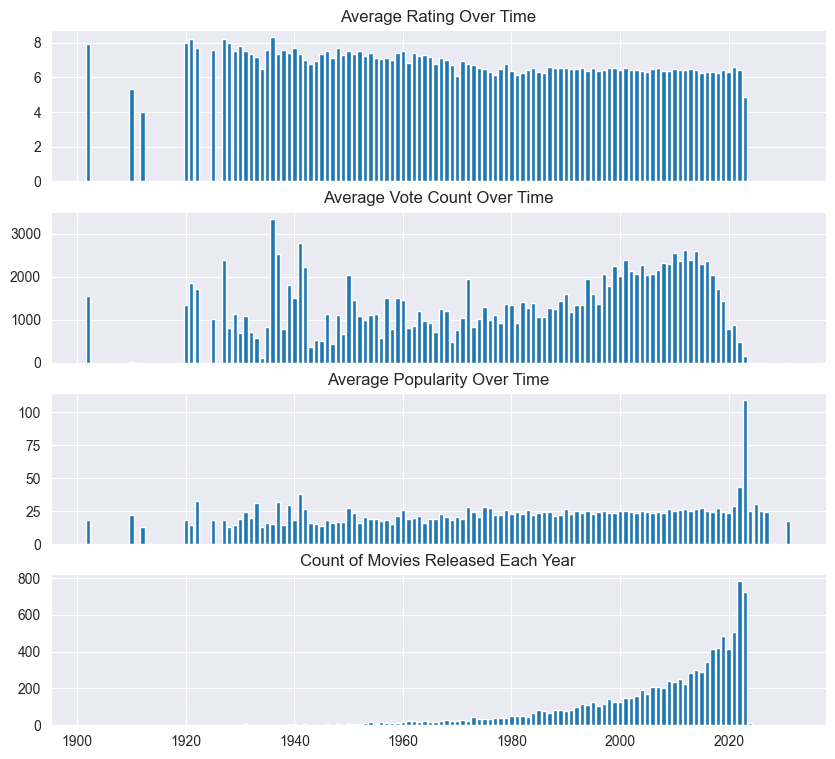

In [7]:
# visualize
fig, ax = plt.subplots(figsize=(10, 5), nrows=4, ncols=1, sharex=True)
plt.subplots_adjust(top=1.5)
ax[0].bar(ar_ot.index, ar_ot.values)
ax[0].set_title('Average Rating Over Time')
ax[1].bar(avc_ot.index, avc_ot.values)
ax[1].set_title('Average Vote Count Over Time')
ax[2].bar(ap_ot.index, ap_ot.values)
ax[2].set_title('Average Popularity Over Time')
ax[3].bar(c_ot.index, c_ot.values)
ax[3].set_title('Count of Movies Released Each Year')
plt.show()

In [29]:
df['year'].min()

1920.0

In [8]:
# seems there's a huge outlier in 2022?
df.sort_values('popularity', ascending=False).iloc[0]
# wow, spiderman was that popular... I imagine it's an outlier but we'll let it stay for now.

index                                                                0
title                              Spider-Man: Across the Spider-Verse
original_language                                                   en
release_date                                                31-05-2023
popularity                                                    3368.627
vote_average                                                       8.5
vote_count                                                        3386
overview             After reuniting with Gwen Stacy, Brooklyn’s fu...
release_date_dt                                    2023-05-31 00:00:00
month                                                              5.0
year                                                            2023.0
day                                                               31.0
Name: 0, dtype: object

# Observations
Seems as though, in general, the number of ratings have fallen, but the average rating has stayed relatively stable, hovering at about 6. This may have implications for more recent recommendations, as the average rating may be skewed by the number of ratings. The average popularity has also increased over time, which may be due to the increase in the number of movies released over time.

I'm not extremely picky about movies, and generally, I only watch them once, so I'm looking for new movies in the proximity of movies I have enjoyed. I think the strategy for this recommendation engine will be to recommend movies that:

- I haven't seen.
- Are in close proximity to a movie I've seen.
- Are not too old.

As a side note, it also appears that the sheer number of movies released every year is continuing to grow into absurdity, which explains why it's so difficult to find anything good if one needs to wade through so many movies.

It also seems as though there are some nonconforming datatypes inside of the data which I'll clean up now.

With this in mind, I continue on to feature selection.

# Model creation
Using TFIDF vectorizer, I'll try to find groups of movies that are the same based on the term frequency.

Once I have the vectorized terms, I will attempt to cluster them using a simple k-means algorithm to see if the genres form naturally.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [10]:
# transform "overview" column into vector
vectorizer = TfidfVectorizer(stop_words='english')
df['overview'] = df['overview'].fillna('')
X = vectorizer.fit_transform(df['overview'])

In [11]:
# attempt initial clustering with kmeans and visualize
# all of the genres i can think of are horror, action, comedy, romance, thriller, mystery, drama, sci-fi, fantasy, adventure, animation, documentary, crime, family, war, history, music, western, tv movie, foreign
# in total that's 21 genres, so i'll try to cluster into 21 groups
kmeans = KMeans(n_clusters=21, random_state=0).fit(X)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [12]:
df['cluster_label'] = kmeans.labels_

In [32]:
df[['title','cluster_label','popularity','overview']]
# high school, coming of age, that sort of movie. Interesting.

,title,cluster_label,popularity,overview
0,Spider-Man: Across the Spider-Verse,18,3368.627,"After reuniting with Gwen Stacy, Brooklyn’s fu..."
14,Resident Evil: Death Island,13,1056.505,"In San Francisco, Jill Valentine is dealing wi..."
18,Fear the Night,13,894.241,During a bachelorette party in a secluded Cali...
21,Justice League: Warworld,16,836.395,"Until now, the Justice League has been a loose..."
22,"Ruby Gillman, Teenage Kraken",3,821.236,"Ruby Gillman, a sweet and awkward high school ..."
...,...,...,...,...
9987,Small Fry,14,12.624,A fast food restaurant mini variant of Buzz fo...
9994,Leprechaun: Back 2 tha Hood,14,12.618,When Emily Woodrow and her friends happen on a...
9995,Porky's II: The Next Day,3,12.617,When the students of Angel Beach High decide t...
9997,Rollerball,9,12.615,"In a corporate-controlled future, an ultra-vio..."


# Model Inspection
Now to take a look at what the model has found. I specified 21 genres, separated by the descriptions of the movies, and if possible, it would be good to find some way to differentiate them so that they can be used as classification for the movies themselves.

In [15]:
# extract the top 5 words for each cluster's TFIDF vector
feats = []
for i in range(21):
    feats.append(
        vectorizer.get_feature_names_out()[np.argsort(kmeans.cluster_centers_[i])[-5:]]
    )

In [16]:
pd.DataFrame(feats)
# seems like the clusters are pretty good! Clearly the 0 cluster is about american war movies,
# 1 is fantasy-esque. 2 is about polic drama, 4 is coming-of-age highschool. Etc.
# I'll try to visualize them now.

,0,1,2,3,4
0,american,civil,world,ii,war
1,kingdom,queen,princess,evil,king
2,force,murder,detective,officer,police
3,teacher,students,student,high,school
4,hollywood,story,series,movie,film
5,life,murder,detective,serial,killer
6,fall,young,life,falls,love
7,ji,hee,jin,min,soo
8,father,year,old,young,girl
9,years,time,mysterious,new,world


# Visualization
I am curious to see if any further insight can be drawn through visualization. It will likely be a mess of dots with 10,000 samples, but perhaps if we cut it down to the last few years? Maybe there is an example of a different cluster's movie which is close to one that I like, which I might enjoy watching?

In [25]:
# attempt to visualize tfidf on 2d scatterplot
# do pca first on tfidf to reduce dimensionality to 2
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
df['pca_x_coordinates'] = X_pca[:,0]
df['pca_y_coordinates'] = X_pca[:,1]
# decompose all of these vectors into a 2d coordinate plane to visualize on bokeh scatterplot

In [26]:
# visualization, because I'm curious
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import viridis
from bokeh.transform import factor_cmap
output_notebook()

Loading BokehJS ...

In [28]:
df = df[df['release_date'] > '2018-01-01']
df['cluster_label'] = df['cluster_label'].astype(str)  # Convert cluster_label to string

source = ColumnDataSource(df)

unique_clusters = sorted(df['cluster_label'].unique())
color_map = factor_cmap('cluster_label', palette=viridis(len(unique_clusters)), factors=unique_clusters)

p = figure(width=800, height=600, tools="pan,box_zoom,reset,wheel_zoom", title="PCA Scatter Plot")
p.scatter(x='pca_x_coordinates', y='pca_y_coordinates', source=source, 
          legend_field='cluster_label', fill_alpha=0.6, size=10, color=color_map)

hover = HoverTool()
hover.tooltips = [("Cluster", "@cluster_label"),("Title", "@title")]
p.add_tools(hover)
show(p)

I've seen Mad Max 2 and I liked it a lot. Closeby is a movie called Enigma, which apparently is about WW2 code cracking team led by Benedict Cumberbatch. I like Benedict Cumberbatch, and I like WW2 movies, so I'll give it a shot. Seems like this recommendation system is working! I may throw it into an app and run it for fun.

# Conclusion
By using the descriptions of movies alone, I was able to build an effective recommendation engine which can be used to recommend movies which are "close" to movies I've already seen using an euclidean distance function (displayed in the streamlit app attached to this repo). Generally speaking, clustering the movies into individual "genre" clusters has allowed me to attach at least some significance to the movie before watching it, so that I can make an informed choice prior to taking the plunge!